# KNN Hyperparameter Analysis

## Objective

The main objective of this analysis is to better understand how the hyperparameter of KNN Classificator affect the model itself. This project will focus on two hyperparameter: the distance function (Minkowski) and the k value.
<br><br>
Also, this analysis will be done in the "Sleep Health and Lifestyle Dataset" (found here: https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset). This dataset includes data about health related indicators (such as quality of sleep and exercise), as well as a BMI qualitative variable (which we will try to predict with our model).<br><br>
Be aware that this data is synthetic, so no real life conclusions can be drawn from it.

## Downloading the data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")

## General Look at Data

In [4]:
df.head()

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


In [6]:
df.describe()

,Person ID,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,187.500000,42.184492,7.132086,7.312834,59.171123,5.385027,70.165775,6816.844920
std,108.108742,8.673133,0.795657,1.196956,20.830804,1.774526,4.135676,1617.915679
min,1.000000,27.000000,5.800000,4.000000,30.000000,3.000000,65.000000,3000.000000
25%,94.250000,35.250000,6.400000,6.000000,45.000000,4.000000,68.000000,5600.000000
50%,187.500000,43.000000,7.200000,7.000000,60.000000,5.000000,70.000000,7000.000000
75%,280.750000,50.000000,7.800000,8.000000,75.000000,7.000000,72.000000,8000.000000
max,374.000000,59.000000,8.500000,9.000000,90.000000,8.000000,86.000000,10000.000000


Some important things to notice:<br>
- All quantitative variables have a mean close to median
- The data is from people with age between 27 and 59, so all data is from adults in working age
- Quality of sleep and Stress Level are on a scale from 1 to 10 (from original documentation). However, it's interesting to see that in both variable the min isn't 1 and the max isn't 10. I have two hypothesis for this: the data doesn't include info about people with very poor/ very good quality of sleep / stress level, or people just don't like answering very low or very high numbers
- Physical Activity Level is in min/day (from original documentation)
- Heart Rate is Resting Hear Rate (from original documentation). It doesn't seem to have a lot of variance in it. All values fall within what is considered a normal hear rate range

In [7]:
# Since "Sleep Disorder" has a lot of null values, let's take a closer look at it
df["Sleep Disorder"].value_counts()

Sleep Disorder
Sleep Apnea    78
Insomnia       77
Name: count, dtype: int64

In [8]:
# Distribution of Gender (about 50% each)
df["Gender"].value_counts()

Gender
Male      189
Female    185
Name: count, dtype: int64

In [9]:
# Distribution of Professions
df["Occupation"].value_counts()

Occupation
Nurse                   73
Doctor                  71
Engineer                63
Lawyer                  47
Teacher                 40
Accountant              37
Salesperson             32
Software Engineer        4
Scientist                4
Sales Representative     2
Manager                  1
Name: count, dtype: int64

Clearly the dataset focus in a few professions more than others. We can expect the model to have a better accuracy for nurses, doctors and engineers than for sofware engineers, for example.

In [10]:
# Distribution of BMI classes
df["BMI Category"].value_counts()

BMI Category
Normal           195
Overweight       148
Normal Weight     21
Obese             10
Name: count, dtype: int64

The difference between "Normal" and "Normal Weight" isn't very clear. The discussions in the original webpage of the dataset in Kaggle also don't clarify what they are. It's probably a good idea to merge these too.
<br><br>
Other than than, the distribution seems fine. It's expected to see more people in the "normal" weight category than overweight, and overweight people than obese ones.

Another important thing to mention is that blood pressure, the way is presented, doesn't work as a quantitative variable, but also can't really be used as a quantitative variable either. Because of this, it will be dropped during data cleaning.

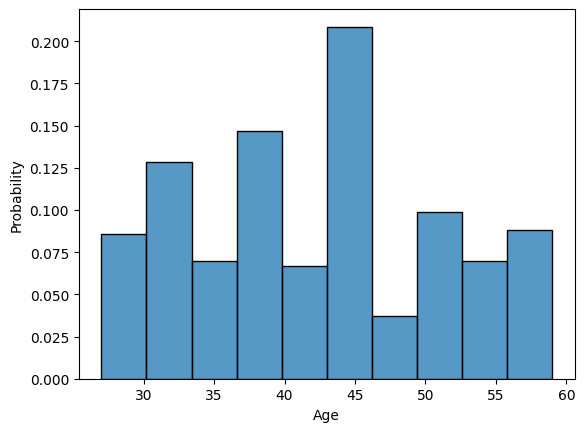

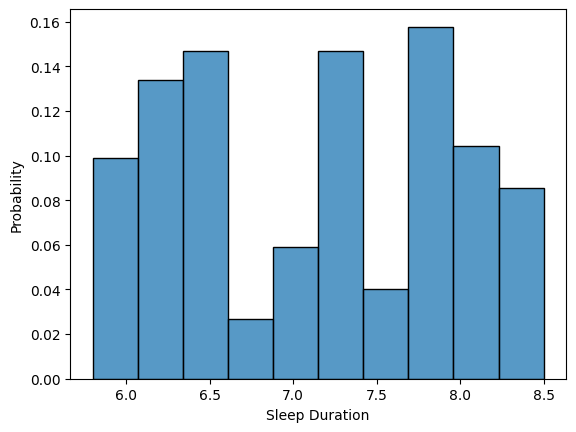

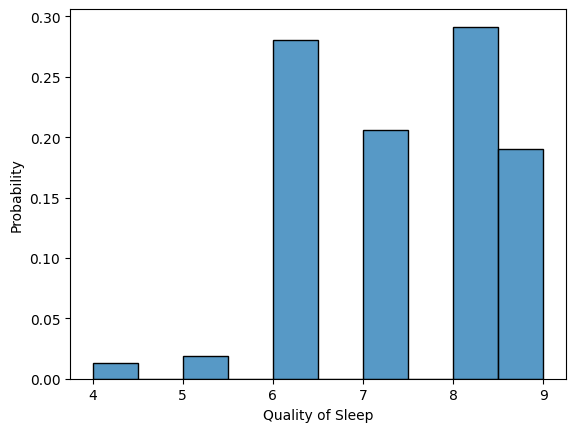

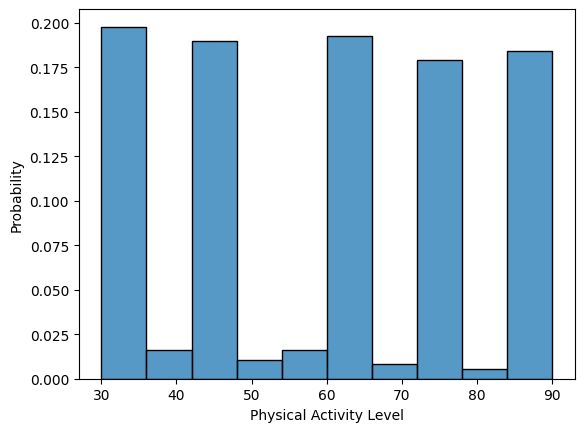

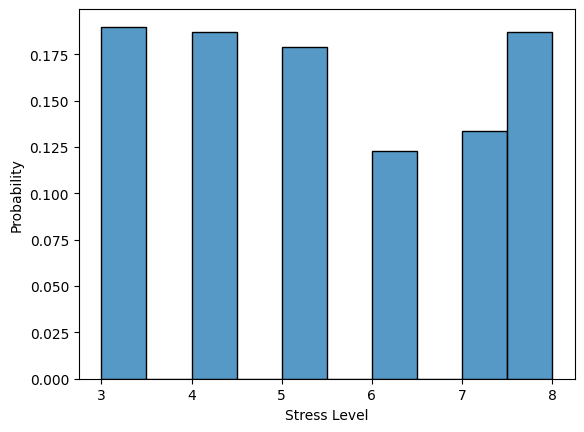

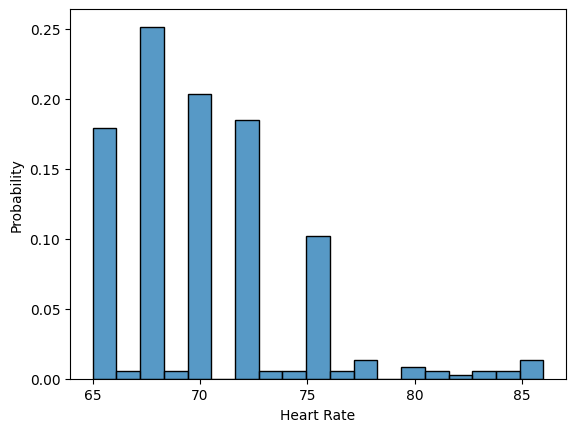

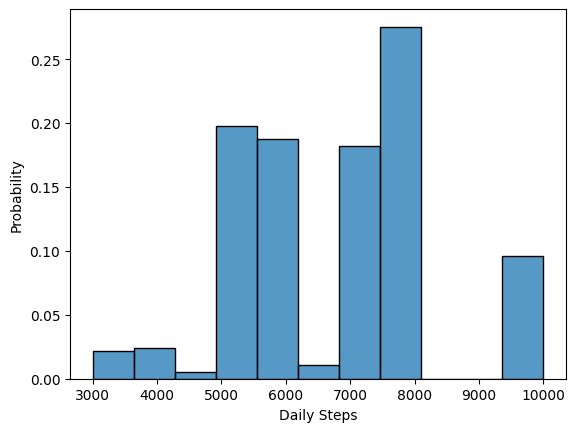

In [11]:
# Histogram of quantitative data data
removed = ["Person ID", "Gender", "Occupation", "BMI Category", "Sleep Disorder", "Blood Pressure"]
for i, col in enumerate(df.columns):
    if col in removed:
        continue
    plt.figure(i)
    sns.histplot(x=col, data=df, stat="probability")

## Data Cleaning

In [12]:
# Copy of original dataset in case we want to reverse the changes
df_original = df.copy()

In [13]:
# Taking a look at the documentation of the dataset, it says that there are three classes: None, Insomnia, Sleep Apnea
# Clearly, the "None" class was included as NA values, so let's fix that
df["Sleep Disorder"].fillna("None", inplace=True)

In [14]:
df["Sleep Disorder"].value_counts()

Sleep Disorder
None           219
Sleep Apnea     78
Insomnia        77
Name: count, dtype: int64

In [15]:
# We should have no null values now
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           374 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


In [16]:
# As explained before, we will drop "Blood Pressure from the dataset"
df = df.drop("Blood Pressure", axis=1)
df

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,None
1,2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None
2,3,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...,...
369,370,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,Sleep Apnea
370,371,Female,59,Nurse,8.0,9,75,3,Overweight,68,7000,Sleep Apnea
371,372,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,Sleep Apnea
372,373,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,Sleep Apnea


In [17]:
# Since we don't know what is the difference between "Normal" and "Normal Weight", it's plausible to make them the same
df["BMI Category"] = df["BMI Category"].replace({"Normal Weight": "Normal"})
df["BMI Category"].value_counts()

BMI Category
Normal        216
Overweight    148
Obese          10
Name: count, dtype: int64

In [18]:
# Since we don't want to include Person ID as a parameter for our predictions, we will also drop it
df = df.drop("Person ID", axis=1)
df

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,None
1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,None
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...
369,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,Sleep Apnea
370,Female,59,Nurse,8.0,9,75,3,Overweight,68,7000,Sleep Apnea
371,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,Sleep Apnea
372,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,Sleep Apnea


In [19]:
# Turning qualitative variables in quantitative ones using one-hot encoding

# Occupation
one_hot = pd.get_dummies(df["Occupation"])
df = df.join(one_hot)
df

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,...,Doctor,Engineer,Lawyer,Manager,Nurse,Sales Representative,Salesperson,Scientist,Software Engineer,Teacher
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,...,False,False,False,False,False,False,False,False,True,False
1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,...,True,False,False,False,False,False,False,False,False,False
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,...,True,False,False,False,False,False,False,False,False,False
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,...,False,False,False,False,False,True,False,False,False,False
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,...,False,False,False,False,True,False,False,False,False,False
370,Female,59,Nurse,8.0,9,75,3,Overweight,68,7000,...,False,False,False,False,True,False,False,False,False,False
371,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,...,False,False,False,False,True,False,False,False,False,False
372,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,...,False,False,False,False,True,False,False,False,False,False


In [20]:
#  Sleep disorder
one_hot = pd.get_dummies(df["Sleep Disorder"])
df = df.join(one_hot)
df

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,...,Manager,Nurse,Sales Representative,Salesperson,Scientist,Software Engineer,Teacher,Insomnia,None,Sleep Apnea
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,...,False,False,False,False,False,True,False,False,True,False
1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,...,False,False,False,False,False,False,False,False,True,False
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,...,False,False,False,False,False,False,False,False,True,False
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,...,False,False,True,False,False,False,False,False,False,True
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,...,False,True,False,False,False,False,False,False,False,True
370,Female,59,Nurse,8.0,9,75,3,Overweight,68,7000,...,False,True,False,False,False,False,False,False,False,True
371,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,...,False,True,False,False,False,False,False,False,False,True
372,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,...,False,True,False,False,False,False,False,False,False,True


In [21]:
# Gender (can be done manually)
df["Gender"] = df["Gender"].replace({"Female": 0, "Male": 1})

In [22]:
df.columns

Index(['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep',
       'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate',
       'Daily Steps', 'Sleep Disorder', 'Accountant', 'Doctor', 'Engineer',
       'Lawyer', 'Manager', 'Nurse', 'Sales Representative', 'Salesperson',
       'Scientist', 'Software Engineer', 'Teacher', 'Insomnia', 'None',
       'Sleep Apnea'],
      dtype='object')

In [23]:
df.isna().sum()

Gender                     0
Age                        0
Occupation                 0
Sleep Duration             0
Quality of Sleep           0
Physical Activity Level    0
Stress Level               0
BMI Category               0
Heart Rate                 0
Daily Steps                0
Sleep Disorder             0
Accountant                 0
Doctor                     0
Engineer                   0
Lawyer                     0
Manager                    0
Nurse                      0
Sales Representative       0
Salesperson                0
Scientist                  0
Software Engineer          0
Teacher                    0
Insomnia                   0
None                       0
Sleep Apnea                0
dtype: int64

In [24]:
# Dropping old parameters
df = df.drop("Occupation", axis=1)
df = df.drop("Sleep Disorder", axis=1)

In [25]:
df

,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Accountant,...,Manager,Nurse,Sales Representative,Salesperson,Scientist,Software Engineer,Teacher,Insomnia,None,Sleep Apnea
0,1,27,6.1,6,42,6,Overweight,77,4200,False,...,False,False,False,False,False,True,False,False,True,False
1,1,28,6.2,6,60,8,Normal,75,10000,False,...,False,False,False,False,False,False,False,False,True,False
2,1,28,6.2,6,60,8,Normal,75,10000,False,...,False,False,False,False,False,False,False,False,True,False
3,1,28,5.9,4,30,8,Obese,85,3000,False,...,False,False,True,False,False,False,False,False,False,True
4,1,28,5.9,4,30,8,Obese,85,3000,False,...,False,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,0,59,8.1,9,75,3,Overweight,68,7000,False,...,False,True,False,False,False,False,False,False,False,True
370,0,59,8.0,9,75,3,Overweight,68,7000,False,...,False,True,False,False,False,False,False,False,False,True
371,0,59,8.1,9,75,3,Overweight,68,7000,False,...,False,True,False,False,False,False,False,False,False,True
372,0,59,8.1,9,75,3,Overweight,68,7000,False,...,False,True,False,False,False,False,False,False,False,True


## Splitting the Training and the Test Datasets

In [26]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42, shuffle=True, stratify=df["BMI Category"])  # I will set the seed to a specific state just to make comparisons more clear

In [27]:
len(train_set), len(test_set)

(299, 75)

<Axes: >

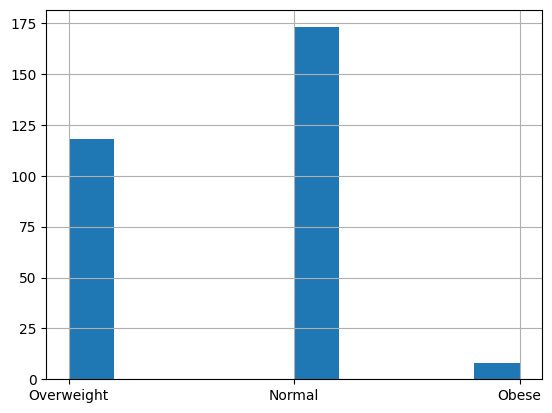

In [28]:
# Checking distributions
train_set["BMI Category"].hist()

<Axes: >

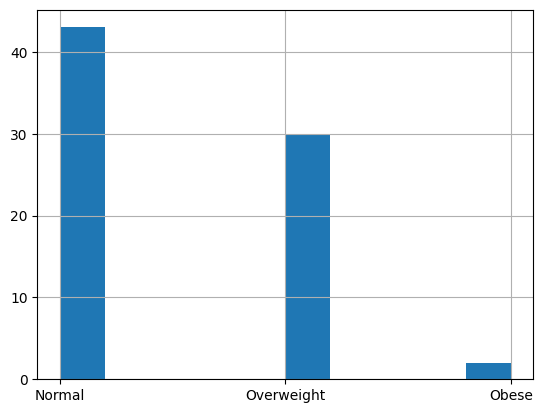

In [29]:
# Checking distributions
test_set["BMI Category"].hist()

In [30]:
# reseting indexes (to make following operations easier)
train_set.reset_index(inplace=True)
test_set.reset_index(inplace=True)

In [31]:
train_set.head()

,index,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,...,Manager,Nurse,Sales Representative,Salesperson,Scientist,Software Engineer,Teacher,Insomnia,None,Sleep Apnea
0,226,0,44,6.6,7,45,4,Overweight,65,6000,...,False,False,False,False,False,False,True,True,False,False
1,340,0,55,8.1,9,75,4,Overweight,72,5000,...,False,True,False,False,False,False,False,False,False,True
2,27,1,30,7.9,7,75,6,Normal,70,8000,...,False,False,False,False,False,False,False,False,True,False
3,112,0,37,7.2,8,60,4,Normal,68,7000,...,False,False,False,False,False,False,False,False,True,False
4,251,0,45,6.8,7,30,6,Overweight,65,6000,...,False,False,False,False,False,False,True,True,False,False


In [32]:
test_set.head()

,index,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,...,Manager,Nurse,Sales Representative,Salesperson,Scientist,Software Engineer,Teacher,Insomnia,None,Sleep Apnea
0,62,1,32,6.2,6,30,8,Normal,72,5000,...,False,False,False,False,False,False,False,False,True,False
1,53,1,32,7.6,7,75,6,Normal,70,8000,...,False,False,False,False,False,False,False,False,True,False
2,353,0,58,8.0,9,75,3,Overweight,68,7000,...,False,True,False,False,False,False,False,False,False,True
3,372,0,59,8.1,9,75,3,Overweight,68,7000,...,False,True,False,False,False,False,False,False,False,True
4,55,1,32,6.0,6,30,8,Normal,72,5000,...,False,False,False,False,False,False,False,False,True,False


## Analysing Data more Depply

In [33]:
# Creating a copy of train_set, since we might make some changes to it
df = train_set.copy()

In [34]:
df

,index,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,...,Manager,Nurse,Sales Representative,Salesperson,Scientist,Software Engineer,Teacher,Insomnia,None,Sleep Apnea
0,226,0,44,6.6,7,45,4,Overweight,65,6000,...,False,False,False,False,False,False,True,True,False,False
1,340,0,55,8.1,9,75,4,Overweight,72,5000,...,False,True,False,False,False,False,False,False,False,True
2,27,1,30,7.9,7,75,6,Normal,70,8000,...,False,False,False,False,False,False,False,False,True,False
3,112,0,37,7.2,8,60,4,Normal,68,7000,...,False,False,False,False,False,False,False,False,True,False
4,251,0,45,6.8,7,30,6,Overweight,65,6000,...,False,False,False,False,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,52,1,32,6.0,6,30,8,Normal,72,5000,...,False,False,False,False,False,False,False,False,True,False
295,103,1,36,6.6,5,35,7,Overweight,74,4800,...,False,False,False,False,False,False,True,False,False,True
296,73,1,33,6.1,6,30,8,Normal,72,5000,...,False,False,False,False,False,False,False,False,True,False
297,314,0,52,8.4,9,30,3,Normal,65,5000,...,False,False,False,False,False,False,False,False,True,False


In [35]:
# Looking for correlation between quantitative variables
variables = ["Age", "Sleep Duration", "Quality of Sleep", "Physical Activity Level", "Stress Level", "Heart Rate", "Daily Steps"]
corr_matrix = df[variables].corr()
corr_matrix

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
Age,1.000000,0.312814,0.445312,0.166738,-0.398288,-0.190183,0.034335
Sleep Duration,0.312814,1.000000,0.881139,0.211786,-0.800339,-0.486105,-0.055545
Quality of Sleep,0.445312,0.881139,1.000000,0.185272,-0.894156,-0.629954,-0.008296
Physical Activity Level,0.166738,0.211786,0.185272,1.000000,-0.019622,0.162574,0.754609
Stress Level,-0.398288,-0.800339,-0.894156,-0.019622,1.000000,0.650555,0.218411
Heart Rate,-0.190183,-0.486105,-0.629954,0.162574,0.650555,1.000000,-0.014429
Daily Steps,0.034335,-0.055545,-0.008296,0.754609,0.218411,-0.014429,1.000000


array([[<Axes: xlabel='Age', ylabel='Age'>,
        <Axes: xlabel='Sleep Duration', ylabel='Age'>,
        <Axes: xlabel='Quality of Sleep', ylabel='Age'>,
        <Axes: xlabel='Physical Activity Level', ylabel='Age'>,
        <Axes: xlabel='Stress Level', ylabel='Age'>,
        <Axes: xlabel='Heart Rate', ylabel='Age'>,
        <Axes: xlabel='Daily Steps', ylabel='Age'>],
       [<Axes: xlabel='Age', ylabel='Sleep Duration'>,
        <Axes: xlabel='Sleep Duration', ylabel='Sleep Duration'>,
        <Axes: xlabel='Quality of Sleep', ylabel='Sleep Duration'>,
        <Axes: xlabel='Physical Activity Level', ylabel='Sleep Duration'>,
        <Axes: xlabel='Stress Level', ylabel='Sleep Duration'>,
        <Axes: xlabel='Heart Rate', ylabel='Sleep Duration'>,
        <Axes: xlabel='Daily Steps', ylabel='Sleep Duration'>],
       [<Axes: xlabel='Age', ylabel='Quality of Sleep'>,
        <Axes: xlabel='Sleep Duration', ylabel='Quality of Sleep'>,
        <Axes: xlabel='Quality of Sleep', yl

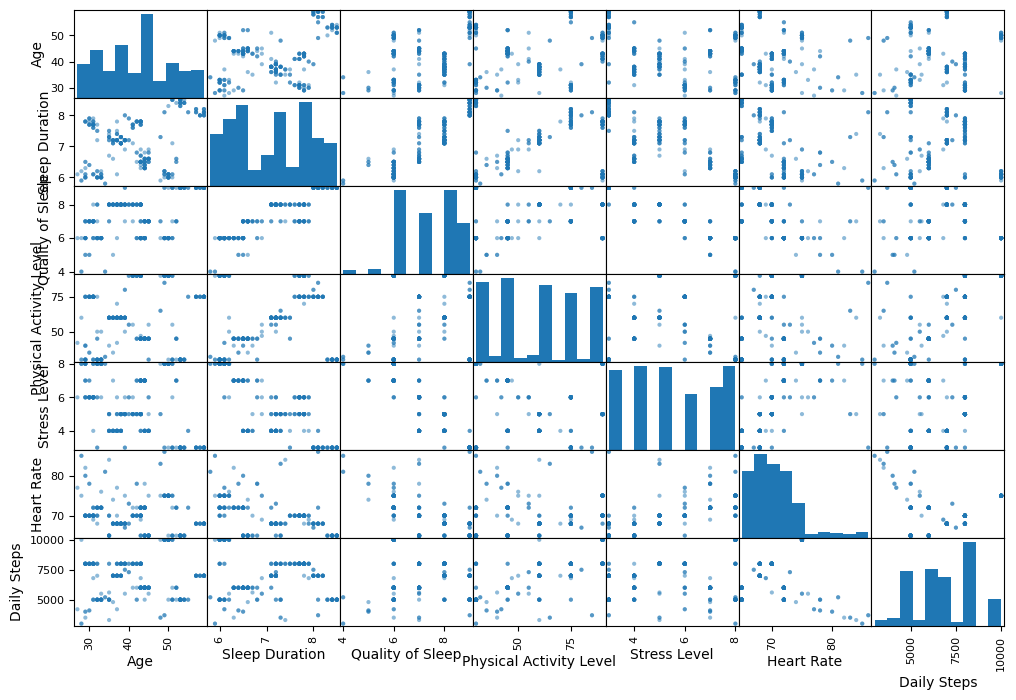

In [36]:
from pandas.plotting import scatter_matrix
attributes = ["Age", "Sleep Duration", "Quality of Sleep", "Physical Activity Level", "Stress Level", "Heart Rate", "Daily Steps"]
scatter_matrix(df[attributes], figsize=(12, 8))

High Positive Correlations:
- Daily Steps and Physical Activity Level (76%)
- Heart Rate and Stress Level (68%)
<br><br>
High Negative Correlations
- Stress Level and Sleep Duration (80%)
<br><br>
In general, there's seems to be some correlation between the data. This will problably negatively impact the predictions, since this creates redundant predictors in a dataset with already few predictors.

## Feature Scaling

In [37]:
# Feature Scaling (using min-max since there is no evidence of impactful outliers)
from sklearn.preprocessing import MinMaxScaler

# train set
scaler = MinMaxScaler()
train_x = train_set.drop("BMI Category", axis=1)
train_y = train_set["BMI Category"]
train_x = pd.DataFrame(data=scaler.fit_transform(train_x), columns=train_x.columns)
train_set = train_x.join(train_y)
train_set = train_set.drop("index", axis=1)
train_set

,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Accountant,Doctor,...,Nurse,Sales Representative,Salesperson,Scientist,Software Engineer,Teacher,Insomnia,None,Sleep Apnea,BMI Category
0,0.0,0.53125,0.296296,0.6,0.250000,0.2,0.000000,0.428571,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,Overweight
1,0.0,0.87500,0.851852,1.0,0.750000,0.2,0.333333,0.285714,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Overweight
2,1.0,0.09375,0.777778,0.6,0.750000,0.6,0.238095,0.714286,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Normal
3,0.0,0.31250,0.518519,0.8,0.500000,0.2,0.142857,0.571429,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Normal
4,0.0,0.56250,0.370370,0.6,0.000000,0.6,0.000000,0.428571,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,Overweight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,1.0,0.15625,0.074074,0.4,0.000000,1.0,0.333333,0.285714,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Normal
295,1.0,0.28125,0.296296,0.2,0.083333,0.8,0.428571,0.257143,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,Overweight
296,1.0,0.18750,0.111111,0.4,0.000000,1.0,0.333333,0.285714,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Normal
297,0.0,0.78125,0.962963,1.0,0.000000,0.0,0.000000,0.285714,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Normal


In [38]:
len(train_x)

299

In [39]:
# test set
scaler = MinMaxScaler()
test_x = test_set.drop("BMI Category", axis=1)
test_y = test_set["BMI Category"]
test_x = pd.DataFrame(data=scaler.fit_transform(test_x), columns=test_x.columns)
test_set = test_x.join(test_y)
test_set = test_set.drop("index", axis=1)
test_set

,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Accountant,Doctor,...,Nurse,Sales Representative,Salesperson,Scientist,Software Engineer,Teacher,Insomnia,None,Sleep Apnea,BMI Category
0,1.0,0.129032,0.115385,0.4,0.000000,1.0,0.35,0.285714,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Normal
1,1.0,0.129032,0.653846,0.6,0.750000,0.6,0.25,0.714286,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Normal
2,0.0,0.967742,0.807692,1.0,0.750000,0.0,0.15,0.571429,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Overweight
3,0.0,1.000000,0.846154,1.0,0.750000,0.0,0.15,0.571429,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Overweight
4,1.0,0.129032,0.038462,0.4,0.000000,1.0,0.35,0.285714,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,1.0,0.290323,0.730769,0.8,0.666667,0.2,0.15,0.571429,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Normal
71,0.0,0.290323,0.500000,0.8,0.500000,0.2,0.15,0.571429,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Normal
72,0.0,0.935484,0.884615,1.0,0.750000,0.0,0.15,0.571429,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Overweight
73,1.0,0.516129,0.153846,0.4,0.250000,0.8,0.35,0.428571,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,Overweight


## Training the Models

We will begin by creating models that use all variables, and then do variable selection

### KNN Model with Euclidian Distance

In [40]:
# separating X and Y
X_train = train_set.drop("BMI Category", axis=1)
Y_train = train_set["BMI Category"]

In [41]:
# model related modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score

In [45]:
# cv has problems using the KNeighborsClassifier by itself because there are multiple classes in Y. This function makes this process easier
# returns the KNN Classifier model with given k and p
def knn_classifier (k=3, p=2):
    neigh = KNeighborsClassifier(n_neighbors=k, p=2)
    bagging = BaggingClassifier(neigh)
    clf = OneVsRestClassifier(bagging)
    return clf

In [46]:
# Accuracy with k-fold
np.random.seed(42)
clf = knn_classifier()
cross_val_score(clf, X_train, Y_train, cv=5, scoring="accuracy")


array([0.91666667, 1.        , 0.93333333, 0.95      , 0.93220339])

### Grid Search

Since we don't know which hyperparameters are going to give the best accuracy, we will test a few of them

In [84]:
# function that makes a grid search based on desired k and p (inside given range)
# returns a dataframe with the values of k and p, the average accuracy on cv and the standard deviation on cv
# ranges are inclusive
def grid_search (X_train, Y_train, k_range=(1,10), p_range=(1,2)):
    np.random.seed(42)
    # dict that keeps the data for dataframe
    data = {
        "k": [],
        "p": [],
        "mean": [],
        "std": []
    }
    for k in range(k_range[0], k_range[1]+1):
        for p in range(p_range[0], p_range[1]+1):
            clf = knn_classifier(k=k, p=p)
            cv_values = cross_val_score(clf, X_train, Y_train, cv=5, scoring="accuracy")
            data["k"].append(k)
            data["p"].append(p)
            data["mean"].append(np.mean(cv_values))
            data["std"].append(np.std(cv_values))
    return pd.DataFrame(data)

In [85]:
# other tests show that the ideal k values are very small, so we will only consider values between 1 and 10
# since the distance function is our main object of analysis, it's interesting to test more values of it
df_grid_search = grid_search(X_train, Y_train, k_range=(1,10), p_range=(1,10))

In [86]:
df_grid_search.head()

,k,p,mean,std
0,1,1,0.949831,0.010546
1,1,2,0.953164,0.012522
2,1,3,0.949831,0.010546
3,1,4,0.953164,0.012522
4,1,5,0.953164,0.012522


### Plotting grid search results

In [87]:
import seaborn as sns

<Axes: xlabel='k', ylabel='mean'>

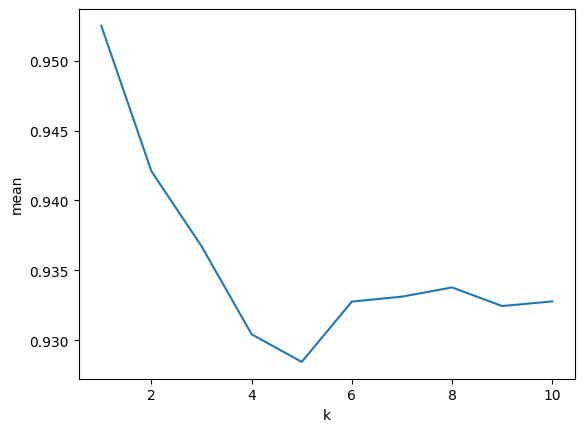

In [88]:
# Plotting k_neighbors vs. average accuracy
k_accuracy = df_grid_search.groupby(["k"]).mean()
sns.lineplot(x=k_accuracy.index, y=k_accuracy["mean"])

<Axes: xlabel='p', ylabel='mean'>

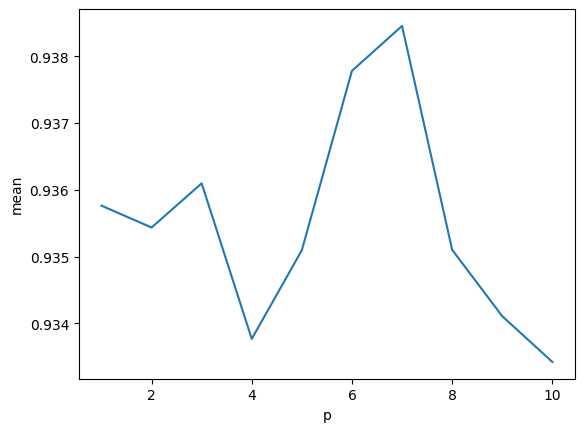

In [89]:
# Plotting p vs. average accuracy
k_accuracy = df_grid_search.groupby(["p"]).mean()
sns.lineplot(x=k_accuracy.index, y=k_accuracy["mean"])

The plot for k neighbors shows that average accuracy is much higher for very small values of k and rapidily decreases, hitting a minimum at k=5. It's seems like accuracy might go up after k=10, but it's seems unlikely that it would return to accuracies in the level of initial k values.<br><br>
On the other hand, for the distance function, accuracy hits a maximum at p=7, and there is no evidence that it would increase after p=10.

### Filtering best models

The plots show that the models can easily get an accuracy above 93%. To select only the best models, we will filter only those above a threshold.

In [90]:
# Selecting minimum accuracy (the choice was based in how many models we want to test)
min_accuracy = 0.95
df_grid_filtered = df_grid_search[df_grid_search["mean"] >= min_accuracy]
df_grid_filtered

,k,p,mean,std
1,1,2,0.953164,0.012522
3,1,4,0.953164,0.012522
4,1,5,0.953164,0.012522
5,1,6,0.953164,0.012522
6,1,7,0.953164,0.012522
7,1,8,0.953107,0.012837
8,1,9,0.953164,0.012522
9,1,10,0.953164,0.012522
16,2,7,0.953164,0.012522


In [91]:
# How many models are there?
len(df_grid_filtered)

9

In [92]:
# Filtering by standard deviation also
max_std = 0.02
df_grid_filtered = df_grid_filtered[df_grid_filtered["std"] <= max_std]
df_grid_filtered

,k,p,mean,std
1,1,2,0.953164,0.012522
3,1,4,0.953164,0.012522
4,1,5,0.953164,0.012522
5,1,6,0.953164,0.012522
6,1,7,0.953164,0.012522
7,1,8,0.953107,0.012837
8,1,9,0.953164,0.012522
9,1,10,0.953164,0.012522
16,2,7,0.953164,0.012522


In [93]:
# How many models are there?
len(df_grid_filtered)

9

In [94]:
# Best model by accuracy and std
df_grid_filtered[(df_grid_filtered["mean"] == df_grid_filtered["mean"].max()) & (df_grid_filtered["std"] == df_grid_filtered["std"].min())]

,k,p,mean,std
1,1,2,0.953164,0.012522
3,1,4,0.953164,0.012522
4,1,5,0.953164,0.012522
5,1,6,0.953164,0.012522
6,1,7,0.953164,0.012522
8,1,9,0.953164,0.012522
9,1,10,0.953164,0.012522
16,2,7,0.953164,0.012522


## Feature Selection

We will consider the forward selection criteria to select the most important features.
<br><br>
Forward selection: aims to choose the model with best accuracy by adding the feature that increases accuracy the most at each step.

In [97]:
# defines forward selection as described above
# returns column names that where included in the best model
def forward_selection (X, Y, k=3, p=2, cv=3):
    np.random.seed(42)
    used_cols = []  # best model uses these columns
    left_cols = list(X.columns)
    clf = knn_classifier(k=k, p=p)
    # since no cols have been used, accuracy is equal to # most common class / # total
    best_accuracy = Y.value_counts()[Y.mode().values[0]] / Y.count()
    while (left_cols):
        best_col = ""
        for col in left_cols:
            tmp_cols = used_cols + [col]
            cv_values = cross_val_score(clf, X[tmp_cols], Y, cv=cv, scoring="accuracy")
            tmp_accuracy = np.mean(cv_values)
            if tmp_accuracy > best_accuracy:
                best_accuracy = tmp_accuracy
                best_col = col
        if not(best_col):
            break
        used_cols.append(best_col)
        left_cols.remove(best_col)
    return used_cols


In [100]:
# Checking for default model (k=3, p=2)
for_cols = forward_selection(X_train, Y_train)
for_cols

['None', 'Daily Steps', 'Nurse', 'Accountant', 'Salesperson']

In [105]:
# accuracy in default model
np.random.seed(42)
clf = knn_classifier()

# with all cols
cv_values = cross_val_score(clf, X_train, Y_train, cv=5, scoring="accuracy")
print(f"With all features: {np.mean(cv_values)}")
# with only forward columns

cv_values = cross_val_score(clf, X_train[for_cols], Y_train, cv=5, scoring="accuracy")
print(f"With forward features: {np.mean(cv_values)}")

With all features: 0.9464406779661017
With forward features: 0.9566101694915254


In [106]:
# See which features are the best in each of our grid search models
np.random.seed(42)
for_accuracies = []
for_features = {}
for index, row in df_grid_filtered.iterrows():
    k = int(row["k"])
    p = int(row["p"])
    for_cols = forward_selection(X_train, Y_train, k=k, p=p)
    clf = knn_classifier(k=k, p=p)
    cv_values = cross_val_score(clf, X_train[for_cols], Y_train, cv=5, scoring="accuracy")
    for_accuracies.append(np.mean(cv_values))
    for_features[(k, p)] = for_cols
    print(f"k = {k}, p = {p}: {for_cols}")
df_grid_filtered.insert(4, "for_mean", for_accuracies)


k = 1, p = 2: ['None', 'Daily Steps', 'Doctor', 'Quality of Sleep']
k = 1, p = 4: ['None', 'Daily Steps', 'Doctor', 'Quality of Sleep']
k = 1, p = 5: ['None', 'Daily Steps', 'Doctor', 'Quality of Sleep']
k = 1, p = 6: ['None', 'Daily Steps', 'Doctor', 'Quality of Sleep']
k = 1, p = 7: ['None', 'Daily Steps', 'Doctor', 'Quality of Sleep']
k = 1, p = 8: ['None', 'Daily Steps', 'Doctor', 'Quality of Sleep']
k = 1, p = 9: ['None', 'Daily Steps', 'Doctor', 'Quality of Sleep']
k = 1, p = 10: ['None', 'Daily Steps', 'Doctor', 'Quality of Sleep']
k = 2, p = 7: ['None', 'Daily Steps']


In [107]:
df_grid_filtered

,k,p,mean,std,for_mean
1,1,2,0.953164,0.012522,0.969887
3,1,4,0.953164,0.012522,0.969887
4,1,5,0.953164,0.012522,0.969887
5,1,6,0.953164,0.012522,0.969887
6,1,7,0.953164,0.012522,0.969887
7,1,8,0.953107,0.012837,0.969887
8,1,9,0.953164,0.012522,0.969887
9,1,10,0.953164,0.012522,0.969887
16,2,7,0.953164,0.012522,0.959944


In [108]:
# Best model by new accuracy
df_grid_filtered[df_grid_filtered["for_mean"] == df_grid_filtered["for_mean"].max()]

,k,p,mean,std,for_mean
1,1,2,0.953164,0.012522,0.969887
3,1,4,0.953164,0.012522,0.969887
4,1,5,0.953164,0.012522,0.969887
5,1,6,0.953164,0.012522,0.969887
6,1,7,0.953164,0.012522,0.969887
7,1,8,0.953107,0.012837,0.969887
8,1,9,0.953164,0.012522,0.969887
9,1,10,0.953164,0.012522,0.969887


## Testing Models

We will use the models in the testing set. The model with the best accuracy will be choosen as the final model for this study.<br><br>
Each model will use the respective subset of features selected in the forward selection (the features are in the dictionary 'for features').

In [109]:
# Calculating test accuracy
X_test = test_set.drop("BMI Category", axis=1)
Y_test = test_set["BMI Category"]
test_accuracies = []  # keeps track of scores of models
for index, row in df_grid_filtered.iterrows():
    k = int(row["k"])
    p = int(row["p"])
    features = for_features[(k, p)]
    clf = knn_classifier(k=k, p=p)
    clf.fit(X_train[features], Y_train)
    accuracy = clf.score(X_test[features], Y_test)
    print(f"k = {k}, p = {p}: {accuracy}")
    test_accuracies.append(accuracy)
df_grid_filtered.insert(5, "test_mean", test_accuracies)

k = 1, p = 2: 0.9733333333333334
k = 1, p = 4: 0.9733333333333334
k = 1, p = 5: 0.9733333333333334
k = 1, p = 6: 0.9733333333333334
k = 1, p = 7: 0.96
k = 1, p = 8: 0.9733333333333334
k = 1, p = 9: 0.9733333333333334
k = 1, p = 10: 0.9733333333333334
k = 2, p = 7: 0.92


In [110]:
df_grid_filtered

,k,p,mean,std,for_mean,test_mean
1,1,2,0.953164,0.012522,0.969887,0.973333
3,1,4,0.953164,0.012522,0.969887,0.973333
4,1,5,0.953164,0.012522,0.969887,0.973333
5,1,6,0.953164,0.012522,0.969887,0.973333
6,1,7,0.953164,0.012522,0.969887,0.960000
7,1,8,0.953107,0.012837,0.969887,0.973333
8,1,9,0.953164,0.012522,0.969887,0.973333
9,1,10,0.953164,0.012522,0.969887,0.973333
16,2,7,0.953164,0.012522,0.959944,0.920000


In [111]:
# Best model by test accuracy
df_grid_filtered[df_grid_filtered["test_mean"] == df_grid_filtered["test_mean"].max()]

,k,p,mean,std,for_mean,test_mean
1,1,2,0.953164,0.012522,0.969887,0.973333
3,1,4,0.953164,0.012522,0.969887,0.973333
4,1,5,0.953164,0.012522,0.969887,0.973333
5,1,6,0.953164,0.012522,0.969887,0.973333
7,1,8,0.953107,0.012837,0.969887,0.973333
8,1,9,0.953164,0.012522,0.969887,0.973333
9,1,10,0.953164,0.012522,0.969887,0.973333


In [113]:
# Features used by the best model

best_models = df_grid_filtered[df_grid_filtered["test_mean"] == df_grid_filtered["test_mean"].max()]
for index, row in best_models.iterrows():
    k = int(row["k"])
    p = int(row["p"])
    features = for_features[(k, p)]
    print(f"k = {k}, p = {p}: {features}")

k = 1, p = 2: ['None', 'Daily Steps', 'Doctor', 'Quality of Sleep']
k = 1, p = 4: ['None', 'Daily Steps', 'Doctor', 'Quality of Sleep']
k = 1, p = 5: ['None', 'Daily Steps', 'Doctor', 'Quality of Sleep']
k = 1, p = 6: ['None', 'Daily Steps', 'Doctor', 'Quality of Sleep']
k = 1, p = 8: ['None', 'Daily Steps', 'Doctor', 'Quality of Sleep']
k = 1, p = 9: ['None', 'Daily Steps', 'Doctor', 'Quality of Sleep']
k = 1, p = 10: ['None', 'Daily Steps', 'Doctor', 'Quality of Sleep']


As we can see, there were a lot of different models that tied for best accuracy. All models have k=1, put the distance function varies a lot.<br><br>
One thing that all models have in common is the features selected in forward selection. All of them use the same four features: None, Daily Steps, Doctor and Quality of Sleep

## Predictions by class

How well does these models perform on each class?

In [286]:
# quantity of each possible class
Y_test.value_counts()

BMI Category
Normal        43
Overweight    30
Obese          2
Name: count, dtype: int64

In [115]:
from sklearn.metrics import confusion_matrix
best_model = knn_classifier(k=k, p=p)
features = for_features[(k, p)]
best_model.fit(X_train[features], Y_train)

for index, row in best_models.iterrows():
    k = int(row["k"])
    p = int(row["p"])
    features = for_features[(k, p)]
    model = knn_classifier(k=k, p=p)
    model.fit(X_train[features], Y_train)
    y_true = Y_test
    y_pred = model.predict(X_test[features])
    print(confusion_matrix(y_true, y_pred, labels = Y_test.unique()))
    print()

[[43  0  0]
 [ 2 28  0]
 [ 0  0  2]]

[[43  0  0]
 [ 2 28  0]
 [ 0  0  2]]

[[43  0  0]
 [ 2 28  0]
 [ 0  0  2]]

[[43  0  0]
 [ 2 28  0]
 [ 0  0  2]]

[[43  0  0]
 [ 2 28  0]
 [ 0  0  2]]

[[43  0  0]
 [ 3 27  0]
 [ 0  0  2]]

[[43  0  0]
 [ 2 28  0]
 [ 0  0  2]]



Clearly, the models have a good performance in all classes. The only wrong prediction was in the Overweight class (2 wrong prediction out of 30, so a small error rate).

## Conclusion

What were the parameters of the best model?<br>
The best models used n_neighbours = 1 and Minkowski metric of p = 2, 4, 5, 6, 8, 9, 10.<br><br>

What was the accuracy of this model?<br>
The models had an accuracy of about 96.99% in the train set (using k-fold with cv = 5) after feature selection and 97.33% in the test set.<br><br>

Does the model perform very differently in each of the classes?<br>
No. The performance was high in all three classes (having no wrong predictions in "Normal" and "Obese" and only 2 out of 30 wrong prediction in "Overweight").<br><br>

What features were considered relevant in predicting BMI Category?
"None" (if has sleep disorder or not), Daily Steps, "Doctor" (if is a doctor or not) and Quality of Sleep.<br>
However, it's important to consider that, because some variables had correlation with these, the following variable can be considered to have at least some relevance: Physical Activity Level (76% correlation with Daily Steps).

This study shows that using a different metric of distance can be quite good at making a model with better accuracy. By the grid search, models with p between 1 and 10 (which were all the possibles values tested), have a very satisfying accuracy, but the k value had to be very small (only models with k = 1 or k = 2 passed the initial filtering).